In [1]:
!pip install transformers
!pip install scikit-learn
!pip install datasets
!pip install accelerate -U

import matplotlib.pyplot as plt
import numpy as np
from datasets import load_metric

###################################################
# Exercise 4 - Natural Language Processing 67658  #
###################################################


# subset of categories that we will use
category_dict = {'comp.graphics': 'computer graphics',
                 'rec.sport.baseball': 'baseball',
                 'sci.electronics': 'science, electronics',
                 'talk.politics.guns': 'politics, guns'
                 }

def get_data(categories=None, portion=1.):
    """
    Get data for given categories and portion
    :param portion: portion of the data to use
    :return:
    """
    # get data
    from sklearn.datasets import fetch_20newsgroups
    data_train = fetch_20newsgroups(categories=categories, subset='train', remove=('headers', 'footers', 'quotes'),
                                    random_state=21)
    data_test = fetch_20newsgroups(categories=categories, subset='test', remove=('headers', 'footers', 'quotes'),
                                   random_state=21)

    # train
    train_len = int(portion*len(data_train.data))
    x_train = np.array(data_train.data[:train_len])
    y_train = data_train.target[:train_len]
    # remove empty entries
    non_empty = x_train != ""
    x_train, y_train = x_train[non_empty].tolist(), y_train[non_empty].tolist()

    # test
    x_test = np.array(data_test.data)
    y_test = data_test.target
    non_empty = np.array(x_test) != ""
    x_test, y_test = x_test[non_empty].tolist(), y_test[non_empty].tolist()
    return x_train, y_train, x_test, y_test

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 2.2 MB/s eta 0:00:00


In [2]:
# Q1
def linear_classification(portion=1.):
    """
    Perform linear classification
    :param portion: portion of the data to use
    :return: classification accuracy
    """
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score
    tf = TfidfVectorizer(stop_words='english', max_features=1000)
    x_train, y_train, x_test, y_test = get_data(categories=category_dict.keys(), portion=portion)
    #added
    x_train_transformed = tf.fit_transform(x_train)
    model = LogisticRegression()
    model.fit(x_train_transformed, y_train)
    y_predicted = model.predict(tf.transform(x_test))
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy

In [3]:
#Q2
def transformer_classification(portion=1.):
    """
    Transformer fine-tuning.
    :param portion: portion of the data to use
    :return: classification accuracy
    """
    import torch

    class Dataset(torch.utils.data.Dataset):
        """
        Dataset object
        """
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    metric = load_metric("accuracy")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels)

    from transformers import Trainer, TrainingArguments
    from transformers import AutoModelForSequenceClassification, AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained('distilroberta-base', cache_dir=None)
    model = AutoModelForSequenceClassification.from_pretrained('distilroberta-base',
                                                                cache_dir=None,
                                                                num_labels=len(category_dict),
                                                                problem_type="single_label_classification")

    x_train, y_train, x_test, y_test = get_data(categories=category_dict.keys(), portion=portion) #TODO CHANGE portion
    # Our addition
    batch_size = 16
    train_encodings = tokenizer(x_train, truncation=True, padding=True)
    test_encodings = tokenizer(x_test, truncation=True, padding=True)

    train_dataset = Dataset(train_encodings,y_train)
    test_dataset = Dataset(test_encodings,y_test)

    training_args = TrainingArguments(output_dir='.',
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    evaluation_strategy = "epoch",
    logging_steps=batch_size)

    trainer = Trainer(model=model,
                      args=training_args,
                      compute_metrics = compute_metrics,
                      train_dataset = train_dataset,
                      eval_dataset = test_dataset,
                      tokenizer=tokenizer)
    return trainer

In [4]:
#Q3
def zeroshot_classification(portion=1.):
      # see https://huggingface.co/docs/transformers/v4.25.1/en/main_classes/pipelines#transformers.ZeroShotClassificationPipeline
    """
    Perform zero-shot classification
    :param portion: portion of the data to use
    :return: classification accuracy
    """
    from transformers import pipeline
    from sklearn.metrics import accuracy_score
    import torch
    x_train, y_train, x_test, y_test = get_data(categories=category_dict.keys(), portion=portion)
    clf = pipeline("zero-shot-classification", model='cross-encoder/nli-MiniLM2-L6-H768')
    candidate_labels = list(category_dict.values())

    # Added code
    predictions = clf(x_test,candidate_labels)
    category_dict_our = {'computer graphics': 0,
                 'baseball': 1,
                 'science, electronics': 2,
                 'politics, guns': 3
                 }

    y_predictions = [list(category_dict_our.keys()).index(entry['labels'][0]) for entry in predictions]
    return accuracy_score(y_test, y_predictions)




Logistic regression results:


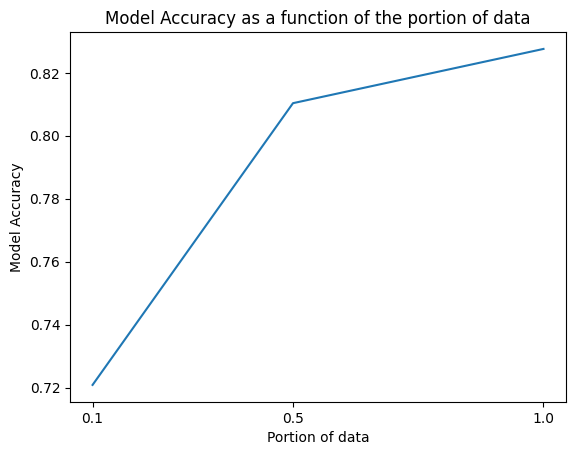


Finetuning results:


<ipython-input-3-37a0e96c04b0>:26: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model average loss and accuracy on validation set for portion  0.1


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.799482,0.796419
2,1.206900,0.444452,0.851459
3,0.494100,0.380643,0.861406


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model average loss and accuracy on validation set for portion  0.5


Epoch,Training Loss,Validation Loss,Accuracy
1,0.366600,0.311755,0.894562
2,0.161300,0.335534,0.901194
3,0.024500,0.390608,0.901857


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model average loss and accuracy on validation set for portion  1.0


Epoch,Training Loss,Validation Loss,Accuracy
1,0.296500,0.330450,0.893899
2,0.112500,0.356665,0.901194
3,0.076000,0.440578,0.903183


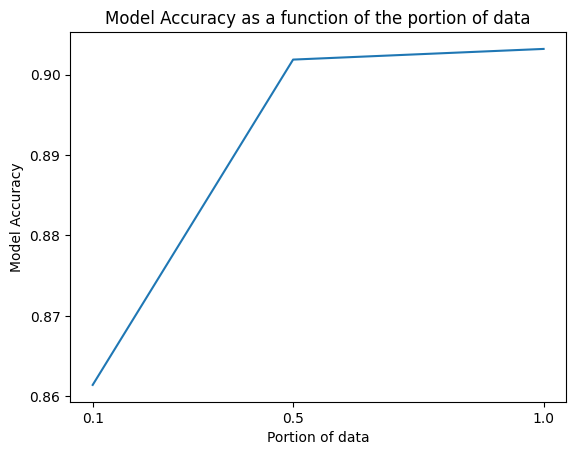


Zero-shot result:


config.json:   0%|          | 0.00/875 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/330 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Accuracy: 0.7712201591511937


In [5]:
if __name__ == "__main__":
    portions = [0.1, 0.5, 1.]
    #Q1
    log_linear_accuracies = []
    print("Logistic regression results:")
    for p in portions:
        log_linear_accuracies.append(linear_classification(p))
    plt.plot(portions, log_linear_accuracies)
    plt.xticks(portions)
    plt.xlabel('Portion of data')
    plt.ylabel('Model Accuracy')
    plt.title('Model Accuracy as a function of the portion of data')
    plt.show()

    # Q2
    print("\nFinetuning results:")
    transformer_accuracies = []
    for p in portions:
        trainer = transformer_classification(portion=p)
        print("model average loss and accuracy on validation set for portion " , str(p))
        trainer.train()
        evaluation_results = trainer.evaluate()
        transformer_accuracies.append(evaluation_results['eval_accuracy'])

    plt.plot(portions, transformer_accuracies)
    plt.xticks(portions)
    plt.xlabel('Portion of data')
    plt.ylabel('Model Accuracy')
    plt.title('Model Accuracy as a function of the portion of data')
    plt.show()

    #Q3
    print("\nZero-shot result:")
    accuracy = zeroshot_classification()
    print("Accuracy:", accuracy)
